# Evaluating Models

# Evaluating Models

We'll be using the following data science libraries (click the links for cheat sheets provided by DataCamp)
* [numpy](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)  (for vectorised math operations)
* [pandas](http://datacamp-community.s3.amazonaws.com/9f0f2ae1-8bd8-4302-a67b-e17f3059d9e8) (for dataframes)
* [keras](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) (for neural networks)

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

The first step to training models is to figure out a way to tell how good a model is. This is similar to test driven development. Before we write our functions, we first define the tests that the functions need to pass. In the world of machine learning, these tests are defined by the data available.

Note that unlike TDD, we don't need to pass all the tests. There will almost always be some difference between the

It's considered good practice to split our data up into a "training set" (for inspection and training models), and a "test set" for model evaluation.

This is to ensure a fair test of the model's ability to generaliset to new examples. The same reason why an exam contains different questions to the practice exams a student learns from.

In [8]:
labelled = pd.read_csv("housing_price_data/train.csv")

In [9]:
# Examine the size of our data
labelled.shape

(1460, 81)

In [10]:
# Split up into training and test sets.
num_rows = labelled.shape[0]
training_set = labelled[:round(num_rows*0.8)]
test_set = labelled[round(num_rows*0.8):]
training_set.to_csv("housing_price_data/training_data.csv",index = False)
test_set.to_csv("housing_price_data/test_data.csv", index = False)


Now that we have a test set, we 

We'll use the mean absolute error. This is the average size of the difference between the predicted value vs the observed value.

Formally, this is defined as

$$  \mathsf{MAE} = \frac{1}{n} * \sum_{i=1}^n |\mathsf{predicted\_value}[i] - \mathsf{actual\_value}[i]|  $$


We now write a function to evaluate how accurate any given predictive model is at predicting on our test set.


In [11]:
def evaluate_model(model_fn):
    '''
    Consumes a function model_fn
    and evaluates its predictive accuracy against 
    the housing prices test set.
    '''
    test_data = pd.read_csv("housing_price_data/test_data.csv")
    actual_values = test_data['SalePrice']
    test_input = test_data.filter(regex='^(?!SalePrice$).*') #Pass in all columns except SalePrice
    predicted_saleprice = model_fn(test_input)
    return np.mean(np.abs(predicted_saleprice-actual_values))

Let's evaluate a very simple predictive heuristic: Sale Price = 100,000 * number of bedrooms.

In [89]:
def bedroom_heuristic(input_data):
    bedrooms = input_data['BedroomAbvGr']
    prediction = 100000*bedrooms
    return(prediction)

In [90]:
evaluate_model(bedroom_heuristic)

132857.79452054793

Exercise: Try and make a heuristic that achieves a lower score.

Exercise: Extend `evaluate_model` to report how fast the model takes to make its predictions.

# Linear Regression

Note that we can easily make new "Bedroom Heuristics" simply by changing the amount of dollars we multiply the number of bedrooms by.

In [43]:
def generate_bedroom_heuristic(a):
    def heuristic(input_data):
        prediction = a * input_data['BedroomAbvGr']
        return(prediction)
    return(heuristic)


The question is now "What's the best amount of dollars to multiply by?" 

Let's start to answer this by using a for loop and trial and error.



In [61]:
model_scores = []
for i in range(200):
    score = evaluate_model(generate_bedroom_heuristic(i*1000))
    model_scores.append(score)

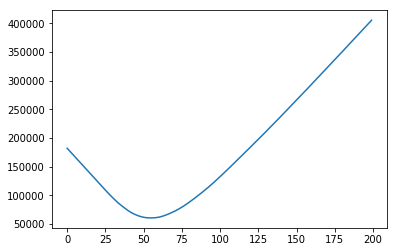

In [62]:
plt.plot(model_scores)

In [63]:
models = pd.DataFrame()
models['Score'] = model_scores

In [64]:
models.loc[models.Score == models.Score.min()]

,Score
54,60874.363014


One issue with this approach is choosing an appropriate level of granularity. In this example we stepped through increments of 1000. But how do we know the optimal value really is \$54,000 and not \$53,765.08 ? We could lower our step size but this would mean increasing our compute time by orders of magnitude. 

# Intermezzo: Optimisation

The science of doing the above effectively is called optimisation. There are some brilliant algorithms for doing optimisation, the most popular in machine learning is called minibatch gradient descent. You can see an outline of this algorithm [here.](https://cs.brown.edu/courses/csci1951-a/assignments/regression.html)

The idea behind the algorithm is to use calculus. As you may recall from high school maths, when the gradient $dy/dx  = 0$  then y is at a minimum or maximimum. This is illustrated in the following diagram.

<img src="https://cs.brown.edu/courses/csci1951-a/assignments/images/gd.png" width="800">


# Linear Regression

Rather than brute force this, we can use a library.

First, let's define our problem:

*Problem*

Find `a` such that `model_evaluate(generate_bedroom_heuristic(a))` attains a minimum value. 



In other words:

Find `a` such that
`mean(abs(a*training_set['BedroomAbvGr'] - training_set['SalePrice']))` attains a minimum value.

Note that we use the train_data set rather than the test_data set to ensure a better chance of generalisation.

We can solve this problem using the Sci Kit learn library

In [93]:
from sklearn import linear_model

predictor = linear_model.LinearRegression()
predictor.fit(training_set[['BedroomAbvGr']],training_set['SalePrice'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We now wrap this up into something that can be evaluated.

In [109]:
def bedroom_linear_model(input_data):
    return(predictor.predict(input_data[['BedroomAbvGr']]))

In [110]:
evaluate_model(bedroom_linear_model)

56628.43522624719

Let's examine the predictions of our linear model

In [114]:
my_data = training_set.copy()

In [115]:
my_data['Predicted'] = bedroom_linear_model(my_data)

In [121]:
my_data['Error'] = my_data['Predicted'] - my_data['SalePrice']

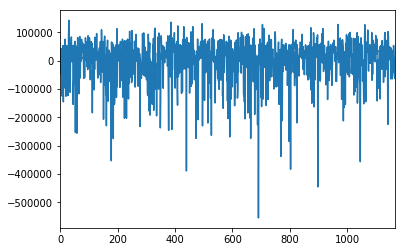

In [122]:
my_data['Error'].plot()

It looks like our model works OK, but there are some instances of severe underprediction.